# 6.8 Final Project Ungraded Assessment
#### Names: Kristy Bell (kab7kr), Yayi Feng (yf7qq), MacKenzye Leroy (zuf9mc)
#### Topic: Loan Default - Lending Club

---
**Assignment Instructions**  
At this point in the course, you should be training and evaluating models and have saved at least one model. Please create a Jupyter Notebook containing a concise summary of at least one model. This should include:

- The type of model (e.g., logistic regression)
- Best hyperparameters used
- Size of the saved model
- And performance metrics

**Research Question:**
For our final project, we aim to investigate different attributes that may contribute to loan default and determine the most effective attributes in predicting loan default.

**Data Source:**
We found a dataset through Kaggle which comes from the world’s largest peer-to-peer lending platform, Lending Club. The data set consists of 153 attributes describing loan status of 2,925,494 loans (1.8 GB) from 2007-2020.  

---



In [1]:
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import functions as F
from pyspark.sql.functions import col, asc,when

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml import Pipeline  
from pyspark.ml.feature import * 
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import IntegerType,BooleanType, FloatType, StringType

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
cwd = os.getcwd()
path = "/project/ds5559/group3loan"

In [3]:
# Read data in csv format
df = spark.read.csv(f'{path}/Loan_status_2007_2020Q3.gzip',header=True,inferSchema=True)
df.count()

2925493

### Constructing Model 1: Predicting current vs late/default loans
As a company distributing loans and collecting loan payments, it is critical for LendingClub to know how much liquid cash they have available.  The more loans they can distibute, the higher profit they will make through interest rates (or taking a cut of what people are lending each other). Furthermore, it is important that LendingClub is able to accurately disclose the risk associated with a loan so that they are fully transparent with their investors. To dive into this problem, our first (main) model, is going to be a classificationn model where we are going to try to predict the "loan status" outcome variable. 

+---------------------------------------------------+-------+----+
|loan_status                                        |count  |prop|
+---------------------------------------------------+-------+----+
|Fully Paid                                         |1497783|0.51|
|Default                                            |433    |0.0 |
|In Grace Period                                    |10028  |0.0 |
|Does not meet the credit policy. Status:Fully Paid |1988   |0.0 |
|Charged Off                                        |362547 |0.12|
|Oct-2015                                           |1      |0.0 |
|Late (31-120 days)                                 |16154  |0.01|
|Issued                                             |2062   |0.0 |
|Current                                            |1031016|0.35|
|Does not meet the credit policy. Status:Charged Off|761    |0.0 |
|Late (16-30 days)                                  |2719   |0.0 |
+---------------------------------------------------+-------+-

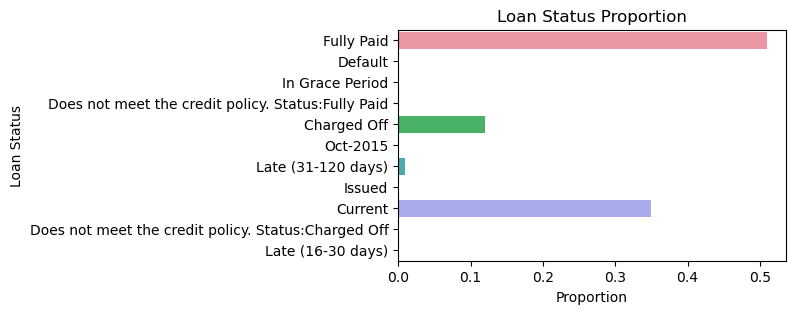

In [4]:
df = df.filter((col("loan_status")!="null")) # filter out value labeled as "null"
tot = df.count()
outcome_stats = df.groupBy("loan_status").count().\
        withColumn('prop', F.round((F.col('count') / tot),2))
outcome_stats.show(truncate=False)


outcome_stats = outcome_stats.toPandas()
plt.figure(figsize=(5,3))
sns.barplot(y='loan_status',x='prop',data=outcome_stats)
plt.ylabel('Loan Status')
plt.xlabel('Proportion')
plt.title('Loan Status Proportion')
plt.show()

Each loan status [explained](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-):  
- Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment. (good)
- Default: Loan has not been current for an extended period of time. Learn more about the difference between “default” and “charge off”. (bad - down money)
- In Grace Period: Loan is past due but within the 15-day grace period. (fine - maybe risky)
- Charged Off: Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”. (bad - down money)
- Late (16-30): Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers. (bad - down money)
- Issued: New loan that has passed all LendingClub reviews, received full funding, and has been issued. (fine - might want to filter out)
- Current: Loan is up to date on all outstanding payments. (good)
- Late (31-120): Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers. (bad - down money)

We are going to wrangle this column to create a binary outcome: 
- {1: LendingClub is out money}  
- {0: if the loan is current/paid}  

We decided to filter out "Issued" loans and "In Grace Period" as those are someone neutral outcomes (neither paid nor late).

In [5]:
df = df.filter((col("loan_status")!="Issued")) # issued means no payment yet
df = df.filter((col("loan_status")!="In Grace Period")) # in grace period means only 0 to 15 days

outcome_column = when((df.loan_status == "Default")|\
                      (df.loan_status == "Charged Off")|\
                      (df.loan_status == "Late (31-120 days)")|\
                      (df.loan_status == "Does not meet the credit policy. Status:Charged Off")|\
                      (df.loan_status ==  "Late (16-30 days)"), 1).otherwise(0)

df = df.withColumn("lose_money", outcome_column)
df.groupBy("lose_money").count().\
        withColumn('prop', F.round((F.col('count') / tot),2)).show(truncate=False)

+----------+-------+----+
|lose_money|count  |prop|
+----------+-------+----+
|1         |382614 |0.13|
|0         |2530788|0.87|
+----------+-------+----+



As expected, we have a data imbalance where the target class (default) appears only in 13% of observations. 

**Feature selecting, filtering, engineering**

In [6]:
# ---- Feature engineering: ------ #

# make new dti variable that combines individual dti as well as joint dti
df = df.withColumn('DTI', when(df.dti.isNull(), df.dti_joint).otherwise(df.dti))
# filter out strange (non numerical entries)
df = df.filter(df.DTI != 'WI')
df = df.filter(df.DTI != 'SC')

# similarly, make a new variable for annual income that combines
df = df.withColumn('ANNUAL_INC', when(df.annual_inc.isNull(), df.annual_inc_joint).otherwise(df.annual_inc))
df = df.filter(df.ANNUAL_INC != 'MORTGAGE') # filter out weird mortgage value



outcome_var = ["lose_money"]

categorical_vars = ["purpose", "term", "sub_grade","emp_length", \
                    "home_ownership","verification_status"]

numerical_vars = ["loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"]

df = df.select(outcome_var+numerical_vars+categorical_vars)
df.show(2)

+----------+---------+-----+--------------------+---------------+-----------+---------------+----------+---------+-----------+----------+---------+----------+--------------+-------------------+
|lose_money|loan_amnt|  DTI|last_fico_range_high|    total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|    purpose|      term|sub_grade|emp_length|home_ownership|verification_status|
+----------+---------+-----+--------------------+---------------+-----------+---------------+----------+---------+-----------+----------+---------+----------+--------------+-------------------+
|         0|     5000|27.65|                 704|5863.1551866952|       5000|         4975.0|     24000|    13648|credit_card| 36 months|       B2| 10+ years|          RENT|           Verified|
|         1|     2500|    1|                 499|        1014.53|       2500|         2500.0|     30000|     1687|        car| 60 months|       C4|  < 1 year|          RENT|    Source Verified|
+----------+---------+-----+--

In [7]:
df.count()

2913396

**Casting all features to the correct data type**

In [8]:
for var in categorical_vars:
    df = df.withColumn(var,df[var].cast(StringType()))
for var in numerical_vars:
    df = df.withColumn(var,df[var].cast(FloatType()))

In [9]:
df.dtypes

[('lose_money', 'int'),
 ('loan_amnt', 'float'),
 ('DTI', 'float'),
 ('last_fico_range_high', 'float'),
 ('total_pymnt', 'float'),
 ('funded_amnt', 'float'),
 ('funded_amnt_inv', 'float'),
 ('ANNUAL_INC', 'float'),
 ('revol_bal', 'float'),
 ('purpose', 'string'),
 ('term', 'string'),
 ('sub_grade', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('verification_status', 'string')]

In [10]:
list=["purpose", "term", "sub_grade","emp_length","home_ownership","verification_status","loan_amnt","DTI","last_fico_range_high", "total_pymnt","funded_amnt","funded_amnt_inv", "ANNUAL_INC","revol_bal"]
for i in list: 
    df.filter(col(i).isNull()).show() 

+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+
|lose_money|loan_amnt|DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|purpose|term|sub_grade|emp_length|home_ownership|verification_status|
+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+
+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+

+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+
|lose_money|loan_amnt|DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|p

**Split the data**

In [11]:
training, test = df.randomSplit([0.7, 0.3])

In [12]:
# one hot encode the categorical variables
stringIndexer_purpose = StringIndexer(inputCol="purpose", outputCol="purpose_index")
mod = stringIndexer_purpose.fit(training)
indexed = mod.transform(training)

stringIndexer_term = StringIndexer(inputCol="term", outputCol="term_index")
mod = stringIndexer_term.fit(indexed)
indexed = mod.transform(indexed)

stringIndexer_sub_grade = StringIndexer(inputCol="sub_grade", outputCol="sub_grade_index")
mod = stringIndexer_sub_grade.fit(indexed)
indexed = mod.transform(indexed)

#stringIndexer_emp = StringIndexer(inputCol="emp_length", outputCol="emp_index")
#mod = stringIndexer_emp.fit(indexed)
#indexed = mod.transform(indexed)

stringIndexer_home_ownership = StringIndexer(inputCol="home_ownership", outputCol="home_ownership_index")
mod = stringIndexer_home_ownership.fit(indexed)
indexed = mod.transform(indexed)

stringIndexer_verification_status = StringIndexer(inputCol="verification_status", outputCol="verification_status_index")
mod = stringIndexer_verification_status.fit(indexed)
indexed = mod.transform(indexed)

In [13]:
encoder = OneHotEncoder(inputCols=["purpose_index","term_index",
                                           "sub_grade_index",
                                          "home_ownership_index","verification_status_index"], 
                                outputCols=["purpose_ohe","term_ohe",
                                            "sub_grade_ohe",
                                           "home_ohe","verif_ohe"])
model = encoder.fit(indexed)
encoded = model.transform(indexed)

In [14]:
encoded.show(2)

+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+-----------+----------+---------+----------+--------------+-------------------+-------------+----------+---------------+--------------------+-------------------------+---------------+-------------+--------------+-------------+-------------+
|lose_money|loan_amnt| DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|    purpose|      term|sub_grade|emp_length|home_ownership|verification_status|purpose_index|term_index|sub_grade_index|home_ownership_index|verification_status_index|  sub_grade_ohe|    verif_ohe|   purpose_ohe|     term_ohe|     home_ohe|
+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+-----------+----------+---------+----------+--------------+-------------------+-------------+----------+---------------+--------------------+-------------------------+---------------+--------

In [15]:
encoded.dtypes

[('lose_money', 'int'),
 ('loan_amnt', 'float'),
 ('DTI', 'float'),
 ('last_fico_range_high', 'float'),
 ('total_pymnt', 'float'),
 ('funded_amnt', 'float'),
 ('funded_amnt_inv', 'float'),
 ('ANNUAL_INC', 'float'),
 ('revol_bal', 'float'),
 ('purpose', 'string'),
 ('term', 'string'),
 ('sub_grade', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('verification_status', 'string'),
 ('purpose_index', 'double'),
 ('term_index', 'double'),
 ('sub_grade_index', 'double'),
 ('home_ownership_index', 'double'),
 ('verification_status_index', 'double'),
 ('sub_grade_ohe', 'vector'),
 ('verif_ohe', 'vector'),
 ('purpose_ohe', 'vector'),
 ('term_ohe', 'vector'),
 ('home_ohe', 'vector')]

In [16]:
res = encoded.drop('purpose','term','sub_grade','emp_length','home_ownership','verification_status',\
            'purpose_index','term_index','sub_grade_index','home_ownership_index','verification_status_index',)

In [17]:
res.dtypes

[('lose_money', 'int'),
 ('loan_amnt', 'float'),
 ('DTI', 'float'),
 ('last_fico_range_high', 'float'),
 ('total_pymnt', 'float'),
 ('funded_amnt', 'float'),
 ('funded_amnt_inv', 'float'),
 ('ANNUAL_INC', 'float'),
 ('revol_bal', 'float'),
 ('sub_grade_ohe', 'vector'),
 ('verif_ohe', 'vector'),
 ('purpose_ohe', 'vector'),
 ('term_ohe', 'vector'),
 ('home_ohe', 'vector')]

In [18]:
res.show(2)

+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+---------------+-------------+--------------+-------------+-------------+
|lose_money|loan_amnt| DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|  sub_grade_ohe|    verif_ohe|   purpose_ohe|     term_ohe|     home_ohe|
+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+---------------+-------------+--------------+-------------+-------------+
|         0|    500.0| 0.0|               689.0|   541.2802|      500.0|          500.0|    3300.0|      0.0|(34,[14],[1.0])|(2,[1],[1.0])|    (13,[],[])|(1,[0],[1.0])|(5,[1],[1.0])|
|         0|    500.0|2.15|               539.0|   557.5353|      500.0|          375.0|   33000.0|   3461.0| (34,[9],[1.0])|(2,[1],[1.0])|(13,[3],[1.0])|(1,[0],[1.0])|(5,[1],[1.0])|
+----------+---------+----+--------------------+-----------+-----------+-------------

In [19]:
assembler = VectorAssembler(inputCols=["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", \
                               "home_ohe","verif_ohe", \
                                       "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"
                                ], outputCol="feature_vector")  
vec = assembler.transform(res)

In [20]:
vec.show(1)

+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+---------------+-------------+-----------+-------------+-------------+--------------------+
|lose_money|loan_amnt|DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|  sub_grade_ohe|    verif_ohe|purpose_ohe|     term_ohe|     home_ohe|      feature_vector|
+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+---------------+-------------+-----------+-------------+-------------+--------------------+
|         0|    500.0|0.0|               689.0|   541.2802|      500.0|          500.0|    3300.0|      0.0|(34,[14],[1.0])|(2,[1],[1.0])| (13,[],[])|(1,[0],[1.0])|(5,[1],[1.0])|(63,[13,28,49,54,...|
+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+---------------+-------------+-----------+-------------+-------------+--------------------+


In [21]:
# lr = LogisticRegression(labelCol='lose_money', featuresCol='feature_vector', maxIter=10, regParam=0.01)
# lrModel = lr.fit(vec)

In [22]:
# one hot encode the categorical variables

va = VectorAssembler(inputCols=["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", "emp_ohe",\
                               "home_ohe","verif_ohe",
                                "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"], outputCol="feature_vector")  

scalar = MinMaxScaler(inputCol="feature_vector",outputCol="features")
lr = LogisticRegression(labelCol='lose_money', featuresCol='features', maxIter=10, regParam=0.01)

**Build Pipeline for Logistic Regression**

In [23]:
# one hot encode the categorical variables
stringIndexer_purpose = StringIndexer(inputCol="purpose", outputCol="purpose_index")
stringIndexer_term = StringIndexer(inputCol="term", outputCol="term_index")
stringIndexer_sub_grade = StringIndexer(inputCol="sub_grade", outputCol="sub_grade_index")
#stringIndexer_emp = StringIndexer(inputCol="emp_length", outputCol="emp_index")
stringIndexer_home_ownership = StringIndexer(inputCol="home_ownership", outputCol="home_ownership_index")
stringIndexer_verification_status = StringIndexer(inputCol="verification_status", outputCol="verification_status_index")

encoder_purpose = OneHotEncoder(inputCol="purpose_index", outputCol="purpose_ohe")
encoder_term = OneHotEncoder(inputCol="term_index", outputCol="term_ohe")
encoder_sub = OneHotEncoder(inputCol="sub_grade_index", outputCol="sub_grade_ohe")
#encoder_emp = OneHotEncoder(inputCol="emp_index", outputCol="emp_ohe")
encoder_home = OneHotEncoder(inputCol="home_ownership_index", outputCol="home_ohe")
encoder_verif = OneHotEncoder(inputCol="verification_status_index", outputCol="verif_ohe")

va = VectorAssembler(inputCols=["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", \
                               "home_ohe","verif_ohe",
                                "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"], outputCol="feature_vector")  

scalar = MinMaxScaler(inputCol="feature_vector",outputCol="features")
lr = LogisticRegression(labelCol='lose_money', featuresCol='features', maxIter=10, regParam=0.01)

In [24]:
# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer_purpose,\
                            stringIndexer_term,\
                            stringIndexer_sub_grade,\
                            # stringIndexer_emp,\
                            stringIndexer_home_ownership,\
                            stringIndexer_verification_status,\
                            encoder_purpose,\
                            encoder_term,\
                            encoder_sub,\
                            # encoder_emp, \
                            encoder_home,\
                            encoder_verif,\
                            va, scalar, lr]) 

In [25]:
model = pipeline.fit(training)

**Make predictions on the test set**

In [26]:
prediction = model.transform(test)
prediction.select('lose_money', 'probability','prediction').show(10, False)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.6902201771290783,0.30977982287092165]|0.0       |
|0         |[0.9807962934154717,0.0192037065845283] |0.0       |
|0         |[0.6109108395476529,0.3890891604523471] |0.0       |
|0         |[0.8297699262077957,0.17023007379220434]|0.0       |
|0         |[0.5071349648640022,0.4928650351359978] |0.0       |
|0         |[0.9208102764539856,0.07918972354601439]|0.0       |
|0         |[0.7480307823200604,0.2519692176799396] |0.0       |
|0         |[0.8291514975398674,0.1708485024601326] |0.0       |
|0         |[0.8520032843012098,0.14799671569879025]|0.0       |
|0         |[0.989268901399286,0.010731098600713973]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows



In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [28]:
evaluator = MulticlassClassificationEvaluator(
    labelCol='lose_money', 
    predictionCol='prediction', 
    metricName='accuracy')

In [29]:
accuracy = evaluator.evaluate(prediction)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.8930748625792329


### Hyperparamter Tuning

#### 5 iterations first (for time/memory constraints)

In [35]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0, .33, .67, 1]) \
    .build()

In [36]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)

In [37]:
cvModel = crossval.setParallelism(4).fit(training)

In [38]:
prediction = cvModel.transform(test)
prediction.select('lose_money', 'probability', 'prediction').show(10, False)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.8681458132698916,0.1318541867301084] |0.0       |
|0         |[0.8665890338196551,0.13341096618034487]|0.0       |
|0         |[0.859390184100227,0.14060981589977295] |0.0       |
|0         |[0.858844216612625,0.141155783387375]   |0.0       |
|0         |[0.8712131582809148,0.12878684171908517]|0.0       |
|0         |[0.8699425548336371,0.13005744516636286]|0.0       |
|0         |[0.8714660060612107,0.12853399393878928]|0.0       |
|0         |[0.8615564114901202,0.1384435885098798] |0.0       |
|0         |[0.8639598633571396,0.1360401366428604] |0.0       |
|0         |[0.8678874242607494,0.13211257573925062]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows



In [47]:
trainingSummary = cvModel.bestModel.stages[-1].summary
trainingSummary

In [63]:
X = zip(cvModel.avgMetrics, paramGrid)

In [64]:
#Results
for x in X:
    print(x)
    print('-------')

(0.8342533161787093, {Param(parent='LogisticRegression_8b19aeda1c87', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LogisticRegression_8b19aeda1c87', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_8b19aeda1c87', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})
-------
(0.8772977944618161, {Param(parent='LogisticRegression_8b19aeda1c87', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LogisticRegression_8b19aeda1c87', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_8b19aeda1c87', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.33})
-------
(0.9388292918343835, {Param(parent='LogisticRegression_8b19aeda1c87

With only 5 iterations, we see that regParam of .1 lead to much vetter results than regParam of .01 and within the .1 groups, we see models with higher alphas perfoming better. 

In [39]:
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|7.457180530431511E-5|5.222321695016413E-5|
|0.003186814800921...| 0.11100417785735602|
|0.004018403417648434|  0.1341316025067144|
|0.004978797879900978|  0.1583855565502835|
|0.006119407538305616| 0.18554162936436885|
|0.007372439842585698|  0.2129438973440764|
|0.008842973245670033|  0.2434795583407938|
|0.010387513516139712|  0.2728551178752611|
|0.012239944952449176|  0.3061921814383766|
|0.014222877048041191| 0.33887645478961503|
| 0.01647471959306392|   0.375048492987168|
|0.018785880619578716|  0.4091166815875858|
| 0.02141114712904199|  0.4452029245001492|
|0.024093472368321444| 0.47911071321993437|
|0.027127753931120508|   0.514406147418681|
|0.030082944185263482|  0.5467770814682185|
| 0.03347144182325804|  0.5795769919427036|
|0.036828302937790165|   0.608348254252462|
| 0.04060152329860472|  0.638331

In [40]:
prediction = cvModel.transform(test)

In [41]:
evaluator = BinaryClassificationEvaluator(labelCol='lose_money')

In [42]:
accuracy = evaluator.evaluate(prediction)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.8691354075021994


#### Increase iterations to 10

In [66]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0, .33, .67, 1]) \
    .build()

In [67]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)

In [68]:
cvModel = crossval.setParallelism(4).fit(training)

In [71]:
X = zip(cvModel.avgMetrics, paramGrid)
for x in X:
    print(x)
    print('-------')

(0.9063238973094435, {Param(parent='LogisticRegression_8b19aeda1c87', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LogisticRegression_8b19aeda1c87', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_8b19aeda1c87', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})
-------
(0.9213610565073191, {Param(parent='LogisticRegression_8b19aeda1c87', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LogisticRegression_8b19aeda1c87', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_8b19aeda1c87', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.33})
-------
(0.9388292918343835, {Param(parent='LogisticRegression_8b19aeda1c

Here again, we see that our best models were all with a regParam of .1 and that the top performing models within those were ones with higher alpha values (.67 and 1)

#### Systematically explore more

Because of memory constraints, we needed to break up the hyperparameter we wanted to test into several different maps and will likely need to conitnue to do so as we continue to test more. 

In [51]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [34]:
paramGrid1 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, .33, .67, 1]) \
    .build()

In [44]:
def fitModelsGetResults(paramGrid):
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)
    cvModel = crossval.setParallelism(4).fit(training)
    prediction = cvModel.transform(test)
    prediction.select('lose_money', 'probability', 'prediction').show(10, False)
    ModelParamsAndResults1 = zip(cvModel.avgMetrics, paramGrid)
    print('Results for Models:')
    for model in ModelParamsAndResults1:
        print(model)
        print('-------')
    print('-----------------')
    print('Results With Best Model:')
    trainingSummary = cvModel.bestModel.stages[-1].summary
    #trainingSummary.roc.show()
    print(f'Area Under ROC: {trainingSummary.areaUnderROC}')
    evaluator = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='accuracy')
    accuracy = evaluator.evaluate(prediction)
    print(f'Test Accuracy = {accuracy}')
    evaluator2 = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='precisionByLabel')
    precision = evaluator2.evaluate(prediction)
    print(f'Precision = {precision}')
    evaluator3 = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='recallByLabel')
    recall = evaluator3.evaluate(prediction)
    print(f'Recall = {recall}')
    #return cvModel.best

In [36]:
paramGrid1 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

In [37]:
paramGrid2 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.5, 0]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

In [38]:
paramGrid3 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [.33, .67]) \
    .build()

In [39]:
paramGrid4 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.5, 0]) \
    .addGrid(lr.elasticNetParam, [.33, .67]) \
    .build()

In [40]:
paramGrid5 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

In [41]:
paramGrid6 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.5, 0]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

In [42]:
paramGrid7 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [.33, .67]) \
    .build()

In [43]:
paramGrid8 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.5, 0]) \
    .addGrid(lr.elasticNetParam, [.33, .67]) \
    .build()

In [44]:
fitModelsGetResults(paramGrid1)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.868857996356743,0.131142003643257]   |0.0       |
|0         |[0.8637312662178113,0.13626873378218873]|0.0       |
|0         |[0.8623359279945854,0.13766407200541464]|0.0       |
|0         |[0.8678459263014223,0.13215407369857768]|0.0       |
|0         |[0.8695290479308113,0.13047095206918868]|0.0       |
|0         |[0.8698634779615791,0.13013652203842085]|0.0       |
|0         |[0.8718547764261096,0.12814522357389035]|0.0       |
|0         |[0.8666568176047066,0.1333431823952934] |0.0       |
|0         |[0.8661444342904405,0.13385556570955948]|0.0       |
|0         |[0.8675071012042088,0.13249289879579118]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.8345301803197265, {Param(parent='Logistic

Best Model Parameters: 
* iterations = 5
* regParam = .1
* alpha = 1 (L1 or Lasso)

In [45]:
fitModelsGetResults(paramGrid2)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.9203864519562448,0.0796135480437552] |0.0       |
|0         |[0.8997658390850601,0.10023416091493986]|0.0       |
|0         |[0.8953841561286702,0.10461584387132983]|0.0       |
|0         |[0.9125010260656474,0.08749897393435258]|0.0       |
|0         |[0.9220707359069862,0.07792926409301382]|0.0       |
|0         |[0.8957862546227372,0.1042137453772628] |0.0       |
|0         |[0.9275563639509188,0.07244363604908122]|0.0       |
|0         |[0.914264201753656,0.08573579824634403] |0.0       |
|0         |[0.9054058158072725,0.09459418419272747]|0.0       |
|0         |[0.8738941995680723,0.12610580043192765]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.8523360049678166, {Param(parent='Logistic

Best Model Parameters: 
* 5 iterations
* regParam = .5
* alpha = 0 (L2 or Ridge)

In [ ]:
#fitModelsGetResults(paramGrid3)
#Caused Memory Issue. Need to revisit when we've figured out how to increase that

Best Model Parameters: 
* INSERT
* INSERT
* INSERT

In [48]:
fitModelsGetResults(paramGrid4)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.8688542815386879,0.13114571846131207]|0.0       |
|0         |[0.8670334661842012,0.13296653381579882]|0.0       |
|0         |[0.866544314227364,0.133455685772636]   |0.0       |
|0         |[0.868491820221952,0.13150817977804796] |0.0       |
|0         |[0.8690954509157334,0.13090454908426663]|0.0       |
|0         |[0.8692158942825325,0.13078410571746746]|0.0       |
|0         |[0.8699365786852046,0.13006342131479542]|0.0       |
|0         |[0.8680678746438794,0.13193212535612064]|0.0       |
|0         |[0.8678858291756466,0.1321141708243534] |0.0       |
|0         |[0.8683708110116539,0.13162918898834608]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.9386146922587311, {Param(parent='Logistic

Best Model Parameters: 
* iterations = 5
* regParam = .5
* alpha = .33

In [ ]:
#fitModelsGetResults(paramGrid5)
#Caused Memory Issue. Need to revisit when we've figured out how to increase that

In [57]:
fitModelsGetResults(paramGrid6)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.9003836499853439,0.09961635001465607]|0.0       |
|0         |[0.8139419511338344,0.18605804886616562]|0.0       |
|0         |[0.7763027661172822,0.22369723388271778]|0.0       |
|0         |[0.8882401086468492,0.11175989135315079]|0.0       |
|0         |[0.9092538308615618,0.09074616913843825]|0.0       |
|0         |[0.9013411174270604,0.09865888257293964]|0.0       |
|0         |[0.9326542786139351,0.06734572138606487]|0.0       |
|0         |[0.8646357530827073,0.13536424691729265]|0.0       |
|0         |[0.8526662786733663,0.1473337213266337] |0.0       |
|0         |[0.8528083714493171,0.1471916285506829] |0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.9472278078764507, {Param(parent='Logistic

Best Model Parameters: 
* Iterations = 10
* regParam = .5
* alpha = 0

In [ ]:
#fitModelsGetResults(paramGrid7)
#Memory Issue

In [60]:
#fitModelsGetResults(paramGrid8)
#Memory Issue

**Notes on Hyperparamters**

While we were able to test a range of hyperparameters and determine that our best hyperparameters so far are iterations = 10, regParam = .5, and Alpha = 0 with an AUC of .947, and accuracy of 86, and precion and recall of .86 and .99 respectively. Unfortunately though, we were not able to explore all of the combinations we wanted to as we had some memory issues. This will be one of our next challenges. 

## Model 2: Random Forest Classifier

**Build Pipeline for Random Forest Classifier**

In [34]:
from pyspark.mllib.tree import RandomForest
from pyspark.ml.classification import RandomForestClassifier

In [30]:
df = df.drop('emp_length')

In [31]:
import random
random.seed(314)
(trainingData, testData) = df.randomSplit([0.7, 0.3])

In [105]:
trainingData.dtypes

[('lose_money', 'int'),
 ('loan_amnt', 'float'),
 ('DTI', 'float'),
 ('last_fico_range_high', 'float'),
 ('total_pymnt', 'float'),
 ('funded_amnt', 'float'),
 ('funded_amnt_inv', 'float'),
 ('ANNUAL_INC', 'float'),
 ('revol_bal', 'float'),
 ('purpose', 'string'),
 ('term', 'string'),
 ('sub_grade', 'string'),
 ('home_ownership', 'string'),
 ('verification_status', 'string')]

In [106]:
# one hot encode the categorical variables
stringIndexer_purpose = StringIndexer(inputCol="purpose", outputCol="purpose_index")
stringIndexer_term = StringIndexer(inputCol="term", outputCol="term_index")
stringIndexer_sub_grade = StringIndexer(inputCol="sub_grade", outputCol="sub_grade_index")
#stringIndexer_emp = StringIndexer(inputCol="emp_length", outputCol="emp_index")
stringIndexer_home_ownership = StringIndexer(inputCol="home_ownership", outputCol="home_ownership_index")
stringIndexer_verification_status = StringIndexer(inputCol="verification_status", outputCol="verification_status_index")

encoder_purpose = OneHotEncoder(inputCol="purpose_index", outputCol="purpose_ohe")
encoder_term = OneHotEncoder(inputCol="term_index", outputCol="term_ohe")
encoder_sub = OneHotEncoder(inputCol="sub_grade_index", outputCol="sub_grade_ohe")
#encoder_emp = OneHotEncoder(inputCol="emp_index", outputCol="emp_ohe")
encoder_home = OneHotEncoder(inputCol="home_ownership_index", outputCol="home_ohe")
encoder_verif = OneHotEncoder(inputCol="verification_status_index", outputCol="verif_ohe")

va = VectorAssembler(inputCols=["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", \
                               "home_ohe","verif_ohe",
                                "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"], outputCol="feature_vector") 
scalar = MinMaxScaler(inputCol="feature_vector",outputCol="features")
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'lose_money')

In [14]:
rf_pipeline = Pipeline(stages=[stringIndexer_purpose,\
                            stringIndexer_term,\
                            stringIndexer_sub_grade,\
                            # stringIndexer_emp,\
                            stringIndexer_home_ownership,\
                            stringIndexer_verification_status,\
                            encoder_purpose,\
                            encoder_term,\
                            encoder_sub,\
                            # encoder_emp, \
                            encoder_home,\
                            encoder_verif,\
                            va, scalar, rf]) 

In [15]:
rf_model = rf_pipeline.fit(trainingData)

In [16]:
rf_predictions = rf_model.transform(testData)

In [17]:
rf_predictions.select("lose_money", "prediction").show(10)

+----------+----------+
|lose_money|prediction|
+----------+----------+
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
+----------+----------+
only showing top 10 rows



In [20]:
evaluator = BinaryClassificationEvaluator(labelCol='lose_money')

In [21]:
accuracy = evaluator.evaluate(rf_predictions)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.9196890212739226


**Random Forest Classifier Hyperparameter Tuning**

In [22]:
from pyspark.ml.tuning import ParamGridBuilder

import numpy as np

In [23]:
def rf_fitModelsGetResults(paramGrid):
    crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)
    cvModel = crossval.setParallelism(4).fit(trainingData)
    prediction = cvModel.transform(testData)
    prediction.select('lose_money', 'probability', 'prediction').show(10, False)
    ModelParamsAndResults1 = zip(cvModel.avgMetrics, paramGrid)
    print('Results for Models:')
    for model in ModelParamsAndResults1:
        print(model)
        print('-------')
    print('-----------------')
    print('Results With Best Model:')
    trainingSummary = cvModel.bestModel.stages[-1].summary
    #trainingSummary.roc.show()
    print(f'Area Under ROC: {trainingSummary.areaUnderROC}')

In [ ]:
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .build()

In [25]:
rf_fitModelsGetResults(lsvc_paramGrid_1)

+----------+-----------------------------------------+----------+
|lose_money|probability                              |prediction|
+----------+-----------------------------------------+----------+
|0         |[0.48541324222122956,0.5145867577787704] |1.0       |
|0         |[0.9663292887637721,0.0336707112362279]  |0.0       |
|0         |[0.5275563782193595,0.4724436217806405]  |0.0       |
|0         |[0.9264008842833699,0.07359911571663008] |0.0       |
|0         |[0.9474520025179084,0.05254799748209152] |0.0       |
|0         |[0.9824431404087117,0.01755685959128835] |0.0       |
|0         |[0.9790084404256754,0.020991559574324616]|0.0       |
|0         |[0.9556848824070806,0.04431511759291937] |0.0       |
|0         |[0.9792416186544168,0.020758381345583086]|0.0       |
|0         |[0.9816375663566149,0.01836243364338499] |0.0       |
+----------+-----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.9018728473992434, {Param(pa

## SVM

In [35]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lsvc = LinearSVC(labelCol='lose_money', featuresCol='features', maxIter=10, regParam=0.1)

# Print the coefficients and intercept for linearsSVC
#print("Coefficients: " + str(lsvcModel.coefficients))
#print("Intercept: " + str(lsvcModel.intercept))

In [36]:
# Fit the pipeline
lsvc_pipeline = Pipeline(stages=[stringIndexer_purpose,\
                            stringIndexer_term,\
                            stringIndexer_sub_grade,\
                            # stringIndexer_emp,\
                            stringIndexer_home_ownership,\
                            stringIndexer_verification_status,\
                            encoder_purpose,\
                            encoder_term,\
                            encoder_sub,\
                            # encoder_emp, \
                            encoder_home,\
                            encoder_verif,\
                            va, scalar, lsvc]) 

In [37]:
lsvc_model = lsvc_pipeline.fit(trainingData)

In [71]:
trainingData.select("lose_money").show(10)

+----------+
|lose_money|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 10 rows



In [62]:
lsvc_predictions = lsvc_model.transform(testData)

In [64]:
lsvc_predictions

DataFrame[lose_money: int, loan_amnt: float, DTI: float, last_fico_range_high: float, total_pymnt: float, funded_amnt: float, funded_amnt_inv: float, ANNUAL_INC: float, revol_bal: float, purpose: string, term: string, sub_grade: string, home_ownership: string, verification_status: string, purpose_index: double, term_index: double, sub_grade_index: double, home_ownership_index: double, verification_status_index: double, purpose_ohe: vector, term_ohe: vector, sub_grade_ohe: vector, home_ohe: vector, verif_ohe: vector, feature_vector: vector, features: vector, rawPrediction: vector, prediction: double]

In [67]:
preds = lsvc_predictions.select("lose_money", 'rawPrediction', "prediction").show(10, False)

+----------+----------------------------------------+----------+
|lose_money|rawPrediction                           |prediction|
+----------+----------------------------------------+----------+
|0         |[0.8848821930866976,-0.8848821930866976]|0.0       |
|0         |[1.064436813476195,-1.064436813476195]  |0.0       |
|0         |[0.8498125861502541,-0.8498125861502541]|0.0       |
|0         |[1.1298021456529592,-1.1298021456529592]|0.0       |
|0         |[1.1942474946394792,-1.1942474946394792]|0.0       |
|0         |[1.2432331493923081,-1.2432331493923081]|0.0       |
|0         |[1.2105109990086393,-1.2105109990086393]|0.0       |
|0         |[1.1577676245946242,-1.1577676245946242]|0.0       |
|0         |[1.176194118683398,-1.176194118683398]  |0.0       |
|0         |[1.2783186905114332,-1.2783186905114332]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows



In [112]:
auc_1

0.8448840499050336

In [40]:
evaluator = BinaryClassificationEvaluator(labelCol='lose_money')

In [41]:
auc = evaluator.evaluate(lsvc_predictions)
print('Test AUC = ', auc)
 

Test Accuracy =  0.9504526916519765


In [42]:
from pyspark.ml.tuning import ParamGridBuilder

import numpy as np

## Hyperparameter tuning

In [59]:
def lsvc_fitModelsGetResults(paramGrid):
    crossval = CrossValidator(estimator=lsvc_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)
    cvModel = crossval.setParallelism(2).fit(training)
    prediction = cvModel.transform(test)
    prediction.select('lose_money', 'probability', 'prediction').show(10, False)
    ModelParamsAndResults1 = zip(cvModel.avgMetrics, paramGrid)
    print('Results for Models:')
    for model in ModelParamsAndResults1:
        print(model)
        print('-------')
    print('-----------------')
    print('Results With Best Model:')
    

    evaluator0 = BinaryClassificationEvaluator(
        labelCol='lose_money')
    AUC = evaluator0.evaluate(prediction)
    print(f'Area Under ROC: {AUC}')
    evaluator = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='accuracy')
    accuracy = evaluator.evaluate(prediction)
    print(f'Test Accuracy = {accuracy}')
    evaluator2 = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='precisionByLabel')
    precision = evaluator2.evaluate(prediction)
    print(f'Precision = {precision}')
    evaluator3 = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='recallByLabel')
    recall = evaluator3.evaluate(prediction)
    print(f'Recall = {recall}')
    #return cvModel.best

In [60]:
test
lsvc_paramGrid_test = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [5]) \
    .addGrid(lsvc.regParam, [.1]) \
    .build()

In [1]:
#lsvc_fitModelsGetResults(lsvc_paramGrid_test)

## ParamGrids

In [44]:
lsvc_paramGrid_1 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [5]) \
    .addGrid(lsvc.regParam, [0.2, 0.1]) \
    .build()

In [45]:
lsvc_paramGrid_2 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [5]) \
    .addGrid(lsvc.regParam, [0.01, 0]) \
    .build()

In [46]:
lsvc_paramGrid_3 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [10]) \
    .addGrid(lsvc.regParam, [0.2, 0.1]) \
    .build()

In [47]:
lsvc_paramGrid_4 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [10]) \
    .addGrid(lsvc.regParam, [0.01, 0]) \
    .build()

In [48]:
lsvc_paramGrid_5 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [15]) \
    .addGrid(lsvc.regParam, [0.2, 0.1]) \
    .build()

In [49]:
lsvc_paramGrid_6 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [15]) \
    .addGrid(lsvc.regParam, [0.01, 0]) \
    .build()

In [53]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_1)

Results for Models:
(0.943844887810273, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.2})
-------
(0.9438764705405798, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.1})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9438054952976132
Test Accuracy = 0.8686136228986575
Precision = 0.8686136228986575
Recall = 1.0
CPU times: user 1.35 s, sys: 305 ms, total: 1.66 s
Wall time: 6min 48s


In [54]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_2)

Results for Models:
(0.9442739326228109, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.01})
-------
(0.9442731806919007, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.0})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9423788859950752
Test Accuracy = 0.8686136228986575
Precision = 0.8686136228986575
Recall = 1.0
CPU times: user 1.27 s, sys: 284 ms, total: 1.56 s
Wall time: 6min 19s


In [55]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_3)

Results for Models:
(0.9497668671548627, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.2})
-------
(0.949185778873461, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.1})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9499645081389538
Test Accuracy = 0.8686124791552768
Precision = 0.8686134726261865
Recall = 0.999998683254153
CPU times: user 1.52 s, sys: 329 ms, total: 1.85 s
Wall time: 6min 29s


In [56]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_4)

Results for Models:
(0.9492488869080358, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.01})
-------
(0.9492384579983859, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.0})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9520346087263439
Test Accuracy = 0.8686136228986575
Precision = 0.8686144660993687
Recall = 0.999998683254153
CPU times: user 1.43 s, sys: 382 ms, total: 1.81 s
Wall time: 6min 19s


In [57]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_5)

Results for Models:
(0.9532450966526542, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.2})
-------
(0.9525510549702851, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.1})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9540702148801593
Test Accuracy = 0.8686136228986575
Precision = 0.8686144660993687
Recall = 0.999998683254153
CPU times: user 1.54 s, sys: 396 ms, total: 1.93 s
Wall time: 6min 29s


In [58]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_6)

Results for Models:
(0.9520945354881023, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.01})
-------
(0.951901862014165, {Param(parent='LinearSVC_3bcceeb80559', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='LinearSVC_3bcceeb80559', name='regParam', doc='regularization parameter (>= 0).'): 0.0})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.952165719148594
Test Accuracy = 0.8686193416155604
Precision = 0.868620276720122
Recall = 0.9999973665083061
CPU times: user 1.77 s, sys: 424 ms, total: 2.19 s
Wall time: 6min 42s


Best Model Hyperparameters = 15 iterations & regParam = .2 (.9541 Test AUC)